In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [3]:
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pre Filtered Treated(only ids that they have 6 months of history from their registered date) and controls with the HasPast flag

In [4]:
%%time
pp_str = 'Pre_Matching_DATA/'

treated2 = pd.read_pickle(pp_str+'treated2Past2.p')
controls = pd.read_pickle(pp_str+'controlsPast.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle('tempHybridSelectionMoreData/random.p')

CPU times: user 7.43 s, sys: 14.6 s, total: 22.1 s
Wall time: 22.1 s


In [5]:
pmpm.head(2)

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0      -3  201908        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1      -3  201909        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   

   CC_OSTEOPOROSIS  CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR  LOB  PREGNANCY  IP_BIN  ER_BIN  ACUTE  IP_C  ER_C  ACUTE_C  IP_BIN6  ER_BIN6  ACUTE6  IP_BIN2  ER_BIN2  ACUTE2  
0              0.0            0.0             0.0          0.0                 0.0      0.0               0.0                     0.0             0.0              0.0        0.0         0.0                 0.0               0.0    1        0.0       0       0      0     0     0        0      0.0      0.0     0.0      0.0      0.0     0.0  
1              0.0            0.0             0.0          0.0                 0.0      0.0               0.0                     0.0             0.0              0.0        0.0         0.0                 0.0               0.0    1        0.0       0       0      0     0     0        0      0.0      0.0     0.0      0.0      0

#### For each of the two clusters formed from the Treated patients form a matched population from the controls.
<div style="background:Aliceblue"> We use hier matching as our matching function</div>

In [6]:
controls2  = controls[controls['HasPast'] == 1].reset_index(drop = True)
controls2.shape, controls.shape

In [7]:
#cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
#columns_to_match = cols


columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

In [8]:
%%time

propensity_func_args = {'match_on':all_columns1, 'neighbors_per_treated': 5, 'onset': "CC_DIABETES", "onset_val" : 0}
matched1, matched_data0 = matched_population(treated2.copy(), 
                                           controls2.copy(),
                                           propensity_func, 
                                           propensity_func_args)

Mathcing Function: propensity_func
Propensity Score Matching...fitting model
Fitted: LogisticRegression
Creating Matched Set...


0it [00:00, ?it/s]

iter: 0


200it [08:21,  2.52s/it]

iter: 200


400it [16:44,  2.50s/it]

iter: 400


600it [25:11,  2.51s/it]

iter: 600


800it [33:40,  2.55s/it]

iter: 800


1000it [42:12,  2.60s/it]

iter: 1000


1200it [50:51,  2.61s/it]

iter: 1200


1367it [58:04,  2.55s/it]


CPU times: user 1h 1min 39s, sys: 26min 15s, total: 1h 27min 55s
Wall time: 1h 2min 2s


### Save data

In [9]:
Path('./propensALLTheory').mkdir(exist_ok = True)
p1 = 'propensALLTheory/'
#matched_data1.to_pickle(p+'match1.p')
treated2.to_pickle(p1+'treated2.p')



### Load matched data

with open(p+'matchesPast.p', 'rb') as handle:
    matched1 = pickle.load(handle)


In [10]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [11]:
from utils import statistics_first_month, p_val, stat_matrices 

### List containing all numerical columns

In [12]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

### Get For each group treated ids and matched controls

In [13]:
controls_all =  pd.DataFrame()
matched_data0 = pd.DataFrame()
controls22 = controls.copy()
controls22 = controls22.set_index('PERS_ID', drop = False)

In [14]:
%%time
counter = 0

for (key, month), val in matched1.items():
    val['RD'] = val.MYR
    first = controls22.loc[val['PERS_ID']].reset_index(drop = True)
    
    new_dat = pd.merge(first, val[['PERS_ID','RD']],  on = 'PERS_ID',)
    new_dat['PERS_ID2'] = new_dat.PERS_ID
    new_dat['PERS_ID'] = new_dat['PERS_ID']+str(counter)    
    filt = new_dat.MYR >= new_dat.RD
    new_dat2 = new_dat[filt].reset_index(drop = True)
    
    #control_groups[group] = new_dat2
    matched_data0 = pd.concat((matched_data0, new_dat2), ignore_index = True)
    controls_all = pd.concat((controls_all, new_dat), ignore_index = True)
    counter += 1
    

CPU times: user 6min 52s, sys: 1min 34s, total: 8min 26s
Wall time: 8min 26s


### Save controls Needed for Diff and Diff

In [15]:
matched_data0.PERS_ID.unique().shape,treated2.PERS_ID.unique().shape

In [16]:
controls_all.to_pickle(p1+'controls_all.p')
matched_data0.to_pickle(p1+'matched.p')

### Start Stats Analysis

In [17]:
from utils import statistics_first_month, p_val, stat_matrices 

### List containing all numerical columns

In [18]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

### Stats First Month(Treated and Matched Controls)

In [19]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated2, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_data0, all_columns, return_array = True)

CPU times: user 3.39 s, sys: 69.1 ms, total: 3.46 s
Wall time: 3.46 s


### Stats First Month(General Pop and Random)

In [20]:
%%time
pmpm_desc = statistics_first_month(pmpm2, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

CPU times: user 2min 26s, sys: 7.38 s, total: 2min 33s
Wall time: 2min 33s


In [21]:
%%time
conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)

CPU times: user 24.7 ms, sys: 4.15 ms, total: 28.8 ms
Wall time: 27.1 ms


## Statistics on matching date

In [22]:
conds_first.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.738           50.808  -0.135  0.892             44.311   47.606
ALLOW_AMT        712.070          708.045   0.047  0.963           1065.926  648.803
MBR_GNDR           0.212            0.269  -4.418  0.000              0.443    0.431
CC_TOBACCO         0.061            0.103  -4.737  0.000              0.074    0.098
CC_PRESSURE        0.001            0.006  -2.031  0.042              0.007    0.007
CC_OBESITY         0.499            0.317  12.987  0.000              0.109    0.228
CC_HYPERTENSION    0.342            0.317   1.830  0.067              0.208    0.249
CC_HYPOTHYROID     0.101            0.090   1.318  0.187              0.047    0.063
CC_DX_CNT          2.912            2.822   1.237  0.216              1.824    2.344
ACUTE2             0.040            0.031   1.448  0.148              0.063    0.052
ACUTE6             0.116            0.106   0.816  0.414              0.063    0.153
IP_BIN6            0.030            0.031  -0.126  0.899              0.021    0.047
ER_BIN6            0.091            0.080   1.225  0.221              0.047    0.116
LOB                0.955            0.819  12.678  0.000              0.756    0.788

In [23]:
full_first

Treated                    Matched Controls                       Test-TC               General Population                         Test-TG                    Random                       Test-TR              
                       mean          std count             mean          std count     t-stat          pval               mean          std   count     t-stat          pval        mean          std count     t-stat          pval
AGE_AT_MIDMONTH   50.738113    12.484023  1367        50.808047    18.290722  6835  -0.135204  8.924542e-01          44.310976    20.053585  356446  11.840960  2.430548e-32   47.606399    19.811819  7876   5.652741  1.625984e-08
ALLOW_AMT        712.070227  2240.844303  1367       708.044623  3007.895613  6835   0.046945  9.625584e-01        1065.926022  6933.418650  356446  -1.886582  5.921741e-02  648.802692  3166.090228  7876   0.708646  4.785620e-01
MBR_GNDR           0.212143     0.408975  1367         0.269495     0.443730  6835  -4.418108  1.008478e-05           0.442749     0.496712  356446 -17.142918  7.544162e-66    0.431056     0.495255  7876 -15.453632  3.291804e-53
CC_TOBACCO         0.061448     0.240239  1367         0.102707     0.303598  6835  -4.736616  2.209672e-06           0.074202     0.262100  356446  -1.796182  7.246636e-02    0.098400     0.297874  7876  -4.347638  1.390855e-05
CC_PRESSURE        0.001463     0.038236  1367         0.005706     0.075327  6835  -2.030792  4.230828e-02           0.007390     0.085645  356446  -2.557523  1.054246e-02    0.006602     0.080991  7876  -2.301931  2.136122e-02
CC_OBESITY         0.498903     0.500182  1367         0.317484     0.465531  6835  12.987128  3.440594e-38           0.108841     0.311440  356446  46.079325  0.000000e+00    0.228035     0.419592  7876  21.377224  5.296178e-99
CC_HYPERTENSION    0.342356     0.474672  1367         0.317045     0.465359  6835   1.829598  6.734633e-02           0.207717     0.405674  356446  12.238795  1.959621e-34    0.249365     0.432673  7876   7.227219  5.320844e-13
CC_HYPOTHYROID     0.100951     0.301374  1367         0.089685     0.285751  6835   1.318352  1.874226e-01           0.047300     0.212281  356446   9.308456  1.304020e-20    0.063484     0.243847  7876   5.050777  4.484259e-07
CC_DX_CNT          2.912217     2.261374  1367         2.822238     2.492747  6835   1.236664  2.162471e-01           1.824419     2.412274  356446  16.644659  3.491967e-62    2.343702     2.439688  7876   8.037223  1.031819e-15
ACUTE2             0.039503     0.209348  1367         0.031309     0.187126  6835   1.447750  1.477253e-01           0.063258     0.243426  356446  -3.602975  3.146389e-04    0.051549     0.237733  7876  -1.758856  7.863515e-02
ACUTE6             0.115582     0.422412  1367         0.106364     0.372385  6835   0.816153  4.144362e-01           0.063258     0.243426  356446   7.901748  2.757940e-15    0.153377     0.475791  7876  -2.754639  5.887196e-03
IP_BIN6            0.029993     0.205649  1367         0.030724     0.193374  6835  -0.126310  8.994893e-01           0.020587     0.141996  356446   2.439382  1.471288e-02    0.046851     0.263725  7876  -2.247805  2.461213e-02
ER_BIN6            0.091441     0.368577  1367         0.079590     0.317452  6835   1.224965  2.206237e-01           0.047286     0.212251  356446   7.647468  2.054816e-14    0.116176     0.402957  7876  -2.120727  3.397134e-02
LOB                0.954645     0.208157  1367         0.818727     0.385272  6835  12.678222  1.715728e-36           0.755775     0.429627  356446  17.106694  1.405094e-65    0.787836     0.408866  7876  14.755466  1.014600e-48

### Statistics Over all dates (treated, controls)

In [24]:
%%time
tr_desc0A = treated2[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_data0[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

CPU times: user 666 ms, sys: 650 µs, total: 666 ms
Wall time: 666 ms


### Statistics Over all dates (general population, Random)

In [25]:
%%time
pmpm_descA = pmpm2[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

CPU times: user 28.2 s, sys: 2.46 s, total: 30.7 s
Wall time: 30.7 s


In [26]:
%%time
conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)

CPU times: user 28.5 ms, sys: 73 µs, total: 28.5 ms
Wall time: 26.8 ms


In [27]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   51.079           52.618 -12.190  0.000             50.379   50.236
ALLOW_AMT        812.538          744.956   2.479  0.013            857.856  706.609
MBR_GNDR           0.196            0.265 -21.460  0.000              0.433    0.429
CC_TOBACCO         0.064            0.103 -17.921  0.000              0.102    0.100
CC_PRESSURE        0.003            0.007  -7.546  0.000              0.013    0.008
CC_OBESITY         0.533            0.352  50.973  0.000              0.255    0.286
CC_HYPERTENSION    0.332            0.339  -2.058  0.040              0.329    0.300
CC_HYPOTHYROID     0.098            0.093   2.231  0.026              0.078    0.075
CC_DX_CNT          3.049            3.072  -1.204  0.229              2.955    2.759
ACUTE2             0.032            0.046  -8.462  0.000              0.060    0.050
ACUTE6             0.101            0.133 -10.295  0.000              0.168    0.150
IP_BIN6            0.026            0.041  -8.870  0.000              0.055    0.049
ER_BIN6            0.079            0.099  -7.328  0.000              0.122    0.111
LOB                0.955            0.826  49.225  0.000              0.802    0.803

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [28]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [29]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [30]:
base_path = './results/'+p1
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [31]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

In [32]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


#### remove %%capture to see output

In [33]:
%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

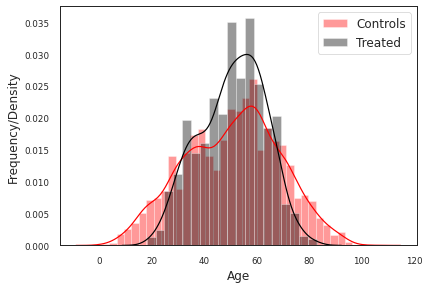

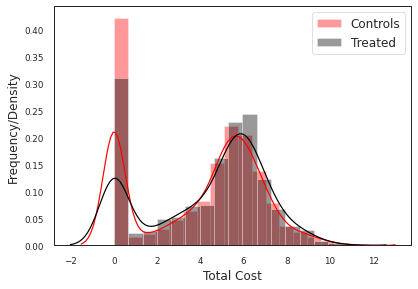

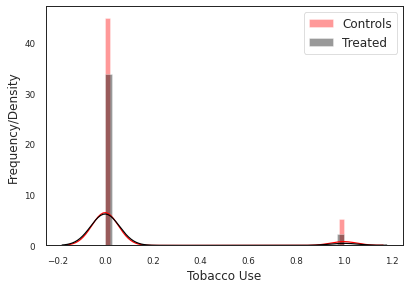

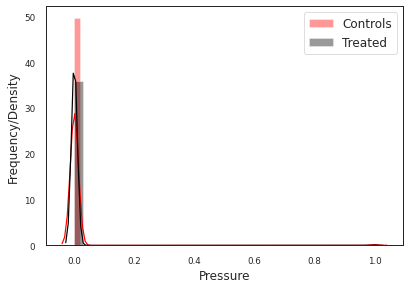

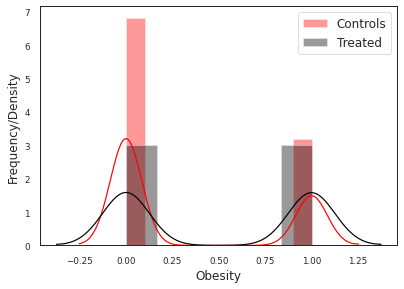

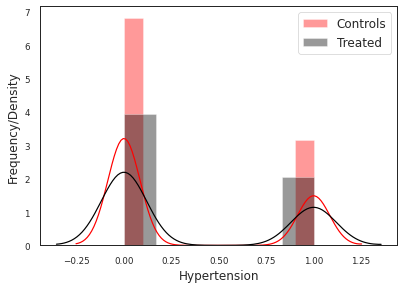

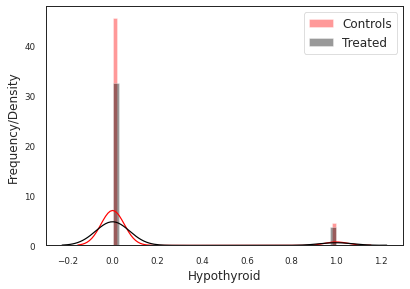

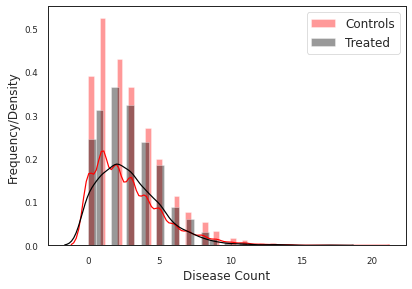

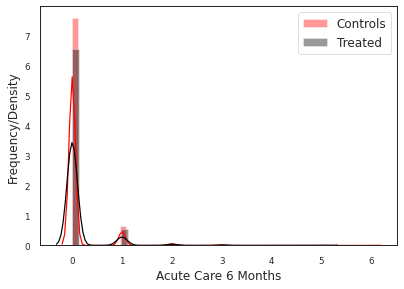

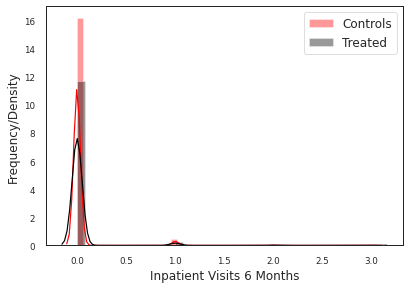

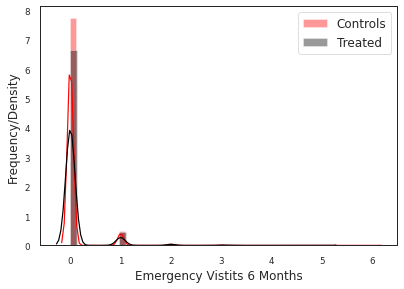

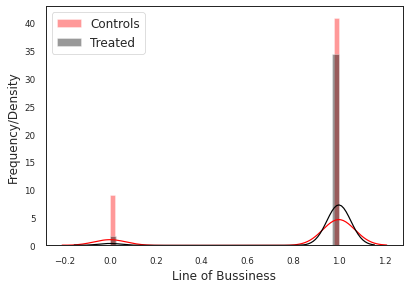

In [34]:
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

Save Three arrays
1. All Statistics
2. Only Means
3. Difference T-Statistic Pvalues

p2 = Path('./res/tabs')
p2.mkdir(parents = True, exist_ok = True)
paths = ['./res/tabs/all_stats.csv', './res/tabs/only_means.csv', './res/tabs/only_stats.csv']
(all_paper, only_means, only_stats) = save_arrays(alli, paths, mapping)

### Save enhanced stats arrays(these will be used at the end)
Arrays with: Statistics in first day, statistics  in the span of monthsm statistiocs from selected columns and all columns

In [35]:
arrays = [conds_first, full_first, conds_firstAllCols, full_firstAllCols,
         conds, full, conds_AllCols, full_AllCols]
names = ['conds_first', 'full_first', 'conds_firstAllCols', 'full_firstAllCols',
         'conds', 'full', 'conds_AllCols', 'full_AllCols']
save_arrays2(arrays, names, base_path+'tables/stats/')